In [1]:
### Importing Packages
### Installed uszipcode using pip install uszipcode to determine information based on zipcode

import os
import warnings
import operator
import uszipcode
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from uszipcode import SearchEngine
from sklearn import model_selection
from collections import defaultdict
warnings.filterwarnings(action="ignore")
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model, ensemble, tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score,GridSearchCV,cross_validate
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures
pd.set_option('display.max_rows', 500)
# !pip install uszipcode

In [2]:
### Function to load the data into notebook 
def Load_File(path) :
    if os.path.isfile(path) :
        data = pd.read_csv(path)
        print("Number of rows in data are %s" % len(data))
        print("Number of columns in data are %s" % len(data.columns))
        print("Data Import is Complete")
        return data
    else:
        print(path + " does not exist. Enter the correct path")
        
### Function to check for the missing values in the data
def check_missing(data):
    col_mv = {}
    for i in list(data.columns):
        null_val = data[i].isnull().sum()
        if null_val!=0:
            col_mv[i] =  int(null_val)
    if col_mv:
        return sorted(col_mv.items(), key=operator.itemgetter(1))
    else:
        print("No Null Values")

### Splitting the data into Independant and Dependant data to pre process
def splitting_data(data, dependant_Feature):
    dependant_data =   pd.DataFrame({'Target' : data_keyme[dependant_Feature]}) 
    dependant_data = dependant_data['Target'].str.replace('$', '')
    dependant_data = pd.DataFrame({'Target': dependant_data})
    Independant_data = data.drop([dependant_Feature], axis=1)
    return Independant_data, dependant_data


### Function to add new Features to the data using USZIPCODE library
def Feature_Engineer(data):
    population = []
    housing_units = []
    radius_in_miles = []
    land_area_in_sqmi = []
    population_density = []
    median_household_income = []
    for i in  data['Zip']:
        search = SearchEngine()
        zip_details = search.by_zipcode(i)
        population.append(zip_details.population)
        housing_units.append(zip_details.housing_units)
        radius_in_miles.append(zip_details.radius_in_miles)
        land_area_in_sqmi.append(zip_details.land_area_in_sqmi)
        population_density.append(zip_details.population_density)
        median_household_income.append(zip_details.median_household_income)

    data['Population'] = population
    data['Radius'] = radius_in_miles
    data['Area'] = land_area_in_sqmi
    data['Housing_Units'] = housing_units
    data['Population_Density'] = population_density
    data['median_household_income'] = median_household_income
    return data


### This is a function to calculate the Variance Inflation Factor. To avoid multicollinearity in the data we use this function
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('Dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]


### Function to remove outliers from the dataset
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out


### Function to plot the barplot for target value vs feature
def barplot(data, data_group_column, attribute, number =25):
    target  = data.groupby(data_group_column)[attribute].mean().nlargest(number)
    z = []
    for i in range(len(target)):
        z.append(i+1)

    plt.figure(figsize=(10,7))
    plt.subplot(211)
    plt.bar(z, list(target), align='center', color ='mediumturquoise')
    labels = target.index
    plt.yticks(fontsize=10)
    plt.xticks(z, labels, fontsize=10, rotation = 90)
    plt.show() 
    

### Function used to print the heatmap to check for the correlations    
def heat_map(data, size_x, size_y):
    f = plt.figure(figsize=(size_x, size_y))
    plt.matshow(data.corr(), fignum=f.number)
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.show()

### Function for Evaluating the Models
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return rmse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return rmse

def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

### Function to pre process the test data which we load
def preprocessing_testdata(eval_data):
    eval_data = Feature_Engineer(eval_data)
    eval_data = eval_data.drop(['Zip', 'Row_ID', 'Location_ID', 'Latitude', 'Longitude', 'Radius', 'Housing_Units'], axis = 1)
    columns_num = [i for i in list(eval_data.columns) if eval_data[i].dtypes != object]
    columns_obj = [i for i in list(eval_data.columns) if eval_data[i].dtypes == object]

    corr_data = eval_data[columns_num]
    obj_data  = eval_data[columns_obj]

    min_max  = MinMaxScaler()
    columns_test = list(corr_data.columns)
    corr_data  = min_max.fit_transform(corr_data[columns_test])
    corr_data  = pd.DataFrame(corr_data, columns=columns_test)

    labelencoder_store_type = LabelEncoder()
    obj_data['Store_Type']  = labelencoder_store_type.fit_transform(obj_data['Store_Type'])

    labelencoder_city = LabelEncoder()
    obj_data['City']  = labelencoder_city.fit_transform(obj_data['City'])

    labelencoder_st = LabelEncoder()
    obj_data['ST']  = labelencoder_st.fit_transform(obj_data['ST'])

    data = pd.concat([obj_data, corr_data], axis=1)
    data = data.fillna(0)
    data['Store_Type'] = data['Store_Type'].astype(int).astype('category')
    data['City'] = data['City'].astype(int).astype('category')
    data['ST'] = data['ST'].astype(int).astype('category')
    return data

In [3]:
### Loading the data 

path_data  = input("Enter the path of data file: ")
data_keyme = Load_File(path_data)
feature_data, target_data = splitting_data(data_keyme, 'Fake_Daily_Revenue')

Enter the path of data file: Downloads/existing_locations_dummy.csv
Number of rows in data are 1000
Number of columns in data are 9
Data Import is Complete


In [4]:
### Adding Features
target_data = target_data.astype(float)
Independant_Data = Feature_Engineer(feature_data)

In [5]:
print("The number of missing value in the Independant Features of data are:")
print(check_missing(Independant_Data))
print('\n')
print("The number of missing value in the Dependant Feature is:")
print(check_missing(target_data))

The number of missing value in the Independant Features of data are:
[('Population', 2), ('Radius', 2), ('Area', 2), ('Housing_Units', 2), ('Population_Density', 2), ('median_household_income', 2)]


The number of missing value in the Dependant Feature is:
No Null Values
None


In [6]:
data_keyme = pd.concat([Independant_Data, target_data], axis=1)
data_keyme = data_keyme.dropna(inplace=False)

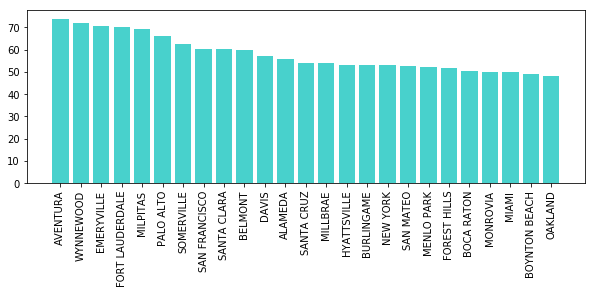

In [7]:
"""Following is the barplot which shows us the top 25 cities based on the revenue they generate."""
barplot(data_keyme, 'City', 'Target')

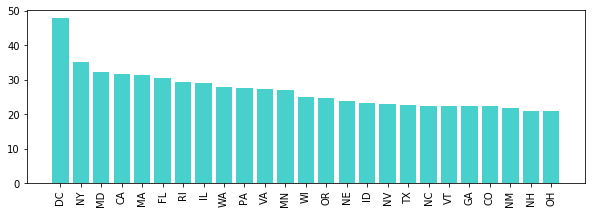

In [8]:
"""Following is the barplot which shows us the top 25 States based on the revenue they generate."""
barplot(data_keyme, 'ST', 'Target')

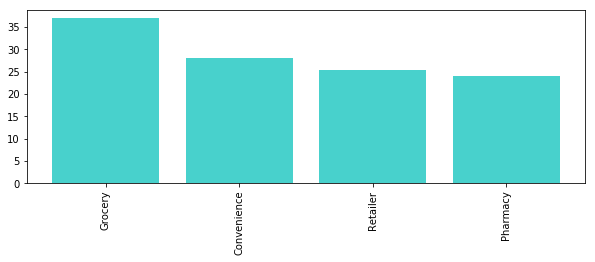

In [9]:
"""Following is the barplot which shows the revenue they generate by store type"""
barplot(data_keyme, 'Store_Type', 'Target')

In [10]:
data_keyme['Row_ID']      = data_keyme['Row_ID'].astype(str)
data_keyme['Location_ID'] = data_keyme['Location_ID'].astype(str)
data_keyme['Zip']         = data_keyme['Zip'].astype(str)
data_keyme['Target']      = data_keyme['Target'].astype(float)

columns_num = [i for i in list(data_keyme.columns) if data_keyme[i].dtypes != object]
columns_obj = [i for i in list(data_keyme.columns) if data_keyme[i].dtypes == object]
corr_data   = data_keyme[columns_num[:-1]]
obj_data    = data_keyme[columns_obj]

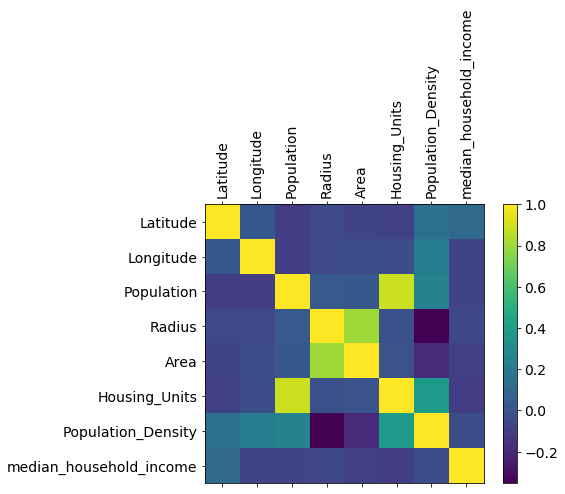

In [11]:
"""From the below heatmaps we can see that how different features are correlated 
to each other. We can use this to avoid multicollinearity in the data"""
heat_map(corr_data, 7, 5)

In [12]:
data_non_corr = calculate_vif_(corr_data)
data_non_corr['Area'] = np.log(data_non_corr['Area'])
data_non_corr['Population_Density'] = np.log(data_non_corr['Population_Density'])

Dropping 'Housing_Units' at index: 5
Dropping 'Latitude' at index: 0
Dropping 'Longitude' at index: 0
Dropping 'Radius' at index: 1
Remaining variables:
Index(['Population', 'Area', 'Population_Density', 'median_household_income'], dtype='object')


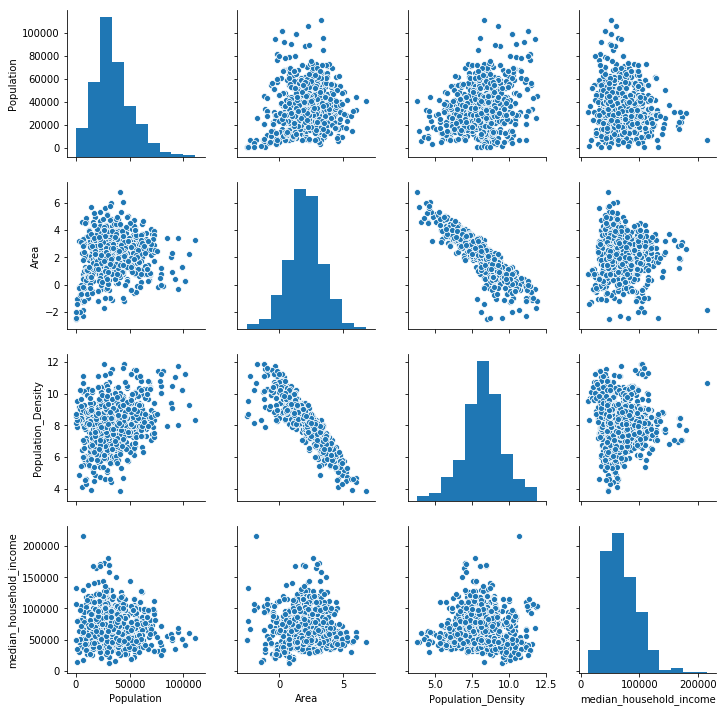

In [13]:
sns.pairplot(data_non_corr)

In [14]:
"""In this cell encoding of categorical variables has been done. Two methods are used for that purpose:
1. Label Encoding
2. Target Encoding or Deviation Encoding
I used target Encoding because of high cardinality of the features i have. There are more than 300 types for each Features.
There are 564 types of cities in the City Feature. There are 45 different States in St Feature. As the data is small, i used
target encoding on this feature. Mapping of target encodings are saved to apply on the test data if Model performs well"""

### Processing data of object data type

obj_data = obj_data.drop(['Row_ID', 'Location_ID', 'Zip'], axis=1)

### Creating Dummies from the data for categorical data STORE_TYPE and ST

labelencoder_store_type = LabelEncoder()
obj_data['Store_Type']  = labelencoder_store_type.fit_transform(obj_data['Store_Type'])
obj_data                = pd.concat([obj_data, target_data], axis = 1)

### Using Deviation Encoding or Target encoding for City and County As the number of variables are more and  it can lead to
### increase in the dimensionality of data
### Save the Encoding File so that we can use it on Test Data

means_city_target  = obj_data.groupby('City')['Target'].mean()
means_state_target = obj_data.groupby('ST')['Target'].mean()

dict_city_target   = dict(zip(means_city_target.index, means_city_target.values))
dict_state_target  = dict(zip(means_state_target.index, means_state_target.values))

obj_data['City'] = obj_data['City'].map(dict_city_target)
obj_data['ST']   = obj_data['ST'].map(dict_state_target)

df_city_target   = pd.DataFrame({'City': list(dict_city_target.keys()), 'Encoding': list(dict_city_target.values())})
df_city_target.to_csv('Desktop/City_Target_Encoding.csv', index = False)

df_state_target  = pd.DataFrame({'State': list(dict_state_target.keys()), 'Encoding': list(dict_state_target.values())})
df_state_target.to_csv('Desktop/State_Target_Encoding.csv', index = False)

In [15]:
### Changing data types

data = pd.concat([obj_data, data_non_corr], axis=1)
data = data.dropna()
data['Store_Type'] = data['Store_Type'].astype(int)

In [16]:
### Standardizing the numerical data using sklearn
### Every Feature has different range. Therefore they are normalized so that every feature has equal importance at the beginning
data_cat     = data[['Store_Type', 'Target']]
data_noncat  = data.drop(['Store_Type','Target'], axis=1)

min_max      = MinMaxScaler()
columns_test = list(data_noncat.columns)
data_noncat  = min_max.fit_transform(data_noncat[list(data_noncat.columns)])
data_noncat  = pd.DataFrame(data_noncat, columns=columns_test)
data         = pd.concat([data_cat, data_noncat], axis=1)
data         = remove_outlier(data, 'Target').dropna()

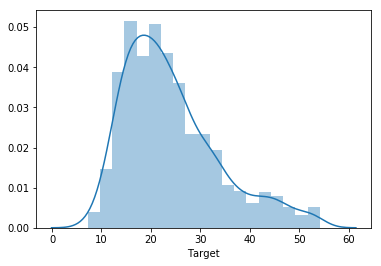

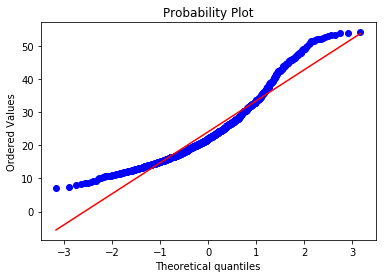

In [17]:
"""Target variable is little bit skewed. It is showing a S shaped plot on Normality curve.
Therefore we need to make our data Normal"""
sns.distplot(data['Target']);
fig = plt.figure()
res = stats.probplot(data['Target'], plot=plt)
data['Target'] = np.log(data['Target'])

In [18]:
### Splitting our data into Training and test. 
"""We are using 70/30 split into Train and Valid Data as we have separate test data"""
Independant = data.drop(['Target'],axis=1)
Dependant = data["Target"]
X_train, X_test, Y_train, Y_test = train_test_split(Independant, Dependant, test_size = 0.3, random_state = 0)

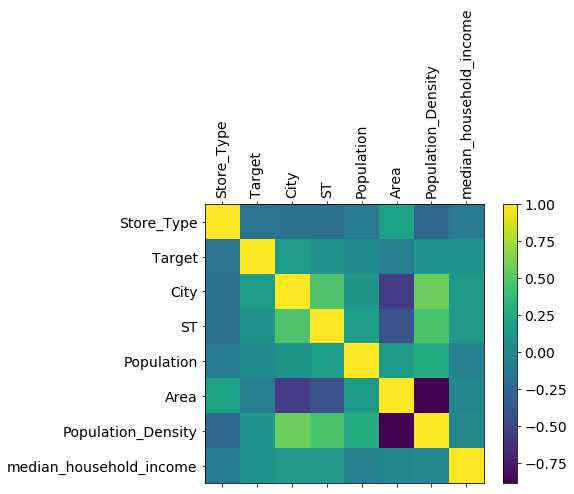

In [19]:
heat_map(data, 7, 5)

# Linear Regression and Backward Elimination using Stats.model

In [20]:
"""We can see from the followng results that most of the feature are not significant which results in a 
bad quality of model. The only Features which makes sense are Store Type and City"""

cols = list(X_train.columns)
pmax = 1
while (len(cols)>0):
    p     = []
    X_1   = X_train[cols]
    X_1   = sm.add_constant(X_1)
    model = sm.OLS(Y_train,X_1).fit()
    print(model.summary())
    p     =   pd.Series(model.pvalues.values[1:],index = cols)      
    pmax  = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     6.491
Date:                Sun, 08 Sep 2019   Prob (F-statistic):           2.09e-07
Time:                        20:24:58   Log-Likelihood:                -270.59
No. Observations:                 642   AIC:                             557.2
Df Residuals:                     634   BIC:                             592.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

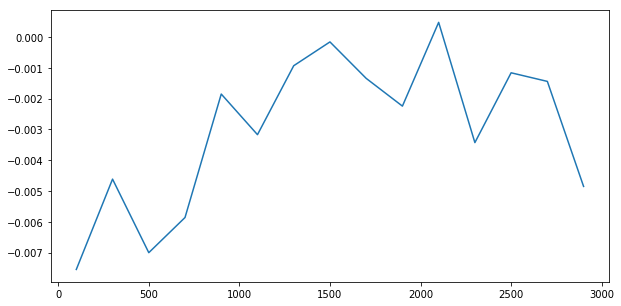

In [21]:
"""Now using Random Forest Regression we are cross verifying that features are not good as the r2 value is
very low and also the error comes out to be high. One of the reasons can be poor encoding of the categorical data"""

rf_score = []
for estimators in range(100,3000,200) :
    rf = RandomForestRegressor(n_estimators = estimators,n_jobs=-1)
    rf_score.append(cross_val_score(rf,X_train,Y_train,cv=3,scoring = 'r2').mean())

fig = plt.figure(figsize=(10,5))
plt.plot(range(100,3000,200),rf_score)

In [22]:
### Initialiting the Prediction Models

RandomForestRegressor_model = RandomForestRegressor(n_estimators=2000)
calc_metrics(X_train, Y_train, X_test, Y_test, RandomForestRegressor_model)

(0.16568533354542084, 0.4065657468507104)

# Changing the Categorical Encoding to Label Encoding for all Features

In [23]:
data_new = data_keyme.drop(['Row_ID', 'Location_ID', 'Zip', 'Latitude', 'Longitude', 'Radius'], axis =1)

columns_num = [i for i in list(data_new.columns) if data_new[i].dtypes != object]
columns_obj = [i for i in list(data_new.columns) if data_new[i].dtypes == object]
corr_data = data_new[columns_num]
obj_data  = data_new[columns_obj]

corr_data['Area'] = np.log(corr_data['Area'])
corr_data['Population_Density'] = np.log(corr_data['Population_Density'])
corr_data['Target'] = np.log(corr_data['Target'])
target = pd.DataFrame({'Target' : corr_data['Target']})
min_max  = MinMaxScaler()
columns_test = list(corr_data.columns)
columns_test = columns_test[:-1]
corr_data  = min_max.fit_transform(corr_data[columns_test])
corr_data  = pd.DataFrame(corr_data, columns=columns_test)

In [24]:
"""Instead of using target encoding we are using Label Encoding for every categorical features."""

labelencoder_store_type = LabelEncoder()
labelencoder_store_type.fit(obj_data['Store_Type'])
obj_data['Store_Type'] = labelencoder_store_type.transform(obj_data['Store_Type'])

labelencoder_city = LabelEncoder()
labelencoder_city.fit(obj_data['City'])
obj_data['City']  = labelencoder_city.fit_transform(obj_data['City'])

labelencoder_st = LabelEncoder()
labelencoder_st.fit(obj_data['ST'])
obj_data['ST']  = labelencoder_st.fit_transform(obj_data['ST'])

In [25]:
data = pd.concat([obj_data, corr_data, target], axis=1)
data = data.dropna()
data['Store_Type'] = data['Store_Type'].astype(int).astype('category')
data['City'] = data['City'].astype(int).astype('category')
data['ST'] = data['ST'].astype(int).astype('category')
data['Housing_Units'] = data['Housing_Units'].astype(int)


Dependant   = data['Target']
Independant = data.drop('Target', axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(Independant, Dependant, test_size = 0.3, random_state = 0)

# Random Forest

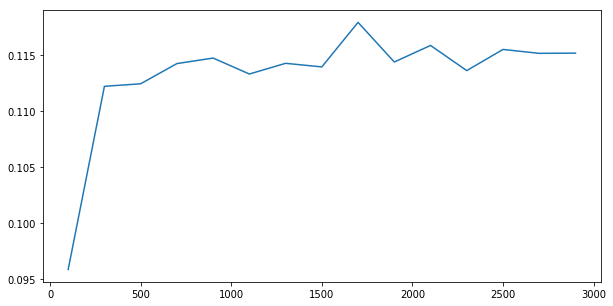

In [26]:
"""From the below results we can see that these are better than the previous model."""

from sklearn.model_selection import cross_val_score,GridSearchCV,cross_validate

rf_score = []
for estimators in range(100,3000,200) :
    rf = RandomForestRegressor(n_estimators = estimators,n_jobs=-1)
    rf_score.append(cross_val_score(rf,X_train,Y_train,cv=3,scoring = 'r2').mean())

fig = plt.figure(figsize=(10,5))
plt.plot(range(100,3000,200),rf_score)

# Hyperparameter Tuning of attributes of model

In [27]:
"""Now We will do the hyperparameter tuning for the model using GridSearchCv"""

rf  = RandomForestRegressor()

param_grid_1 = { 
    'min_samples_split':range(200,1001,200),
    'min_samples_leaf':range(10,71,10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : range(2,10,1)}

gsearch1 = GridSearchCV(estimator = rf,
                        param_grid = param_grid_1, 
                        scoring='r2',n_jobs=-1,
                        iid=False, cv=3)

gsearch1.fit(X_train,Y_train)
gsearch1.best_params_, gsearch1.best_score_


# ({'max_depth': 2,
#   'max_features': 'auto',
#   'min_samples_leaf': 50,
#   'min_samples_split': 200},
#  0.08498054051190677)

In [28]:
rf_best = RandomForestRegressor(n_estimators=500, max_depth=2, 
                                max_features='auto', min_samples_leaf=50,
                               min_samples_split=200, n_jobs=1, random_state=0)

In [29]:
calc_metrics(X_train, Y_train, X_test, Y_test, rf_best)

(0.4592208130505196, 0.49576519921253703)

In [30]:
"""This shows us the importance of Features. We can say that Store_Type has the most impact of Output.
As the value is close to .90, we can assume that this may cause some bias in the system. Also we can see that
Housing Units has zero impact on the output of the model. So we will remove this and run the model again"""

dict(zip(rf_best.feature_importances_, X_train.columns))

{0.8904517584484285: 'Store_Type',
 0.029821614381403926: 'City',
 0.007582857680715028: 'ST',
 0.008848075041787334: 'Population',
 0.020205154335530353: 'Area',
 0.0: 'Housing_Units',
 0.04078365422462328: 'Population_Density',
 0.002306885887511754: 'median_household_income'}

# Gradient Boosting

In [31]:
"""As there can be some bias in the Random Forest model. To avoid that we will use Gradient Boosting model
with GridSearcCV to know about the best parameters. From the results we can see that this model is the best out of all because
r2 score is coming out to be better than the others. Therefore we will choose this model."""

GBoost = GradientBoostingRegressor(learning_rate=0.05, loss='huber', random_state =5)

param_grid_1 = { 
    'min_samples_split':range(200,1001,200),
    'min_samples_leaf':range(10,71,10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : range(2,10,1)}

gsearch1 = GridSearchCV(estimator = GBoost,
                        param_grid = param_grid_1, 
                        scoring='r2',n_jobs=-1,
                        iid=False, cv=3)

gsearch1.fit(X_train,Y_train)
gsearch1.best_params_, gsearch1.best_score_

# ({'max_depth': 4,
#   'max_features': 'auto',
#   'min_samples_leaf': 40,
#   'min_samples_split': 200},
#  0.1417595588149185)


'As there can be some bias in the Random Forest model. To avoid that we will use Gradient Boosting model\nwith GridSearcCV to know about the best parameters. From the results we can see that this model is the best out of all because\nr2 score is coming out to be better than the others. Therefore we will choose this model.'

In [32]:
GBoost_best = GradientBoostingRegressor(learning_rate=0.05, loss='huber', random_state =5,
                                  max_depth=4, max_features='auto', min_samples_leaf=40,
                                  min_samples_split=200)

In [33]:
calc_metrics(X_train, Y_train, X_test, Y_test, GBoost_best)

(0.4045530303528443, 0.4635335802504337)

In [34]:
"""Again from the below we can see that Store_Type is the most Important Feature. But ven the other features has some
significant contribution which is what i was looking for."""
dict(zip(GBoost_best.feature_importances_, X_train.columns))

{0.41660241034963086: 'Store_Type',
 0.22610593205449206: 'City',
 0.10981246175933024: 'ST',
 0.02658815285981128: 'Population',
 0.034701219415977445: 'Area',
 0.0: 'Housing_Units',
 0.11310897613627512: 'Population_Density',
 0.07308084742448295: 'median_household_income'}

In [35]:
X_train = X_train.drop('Housing_Units', axis=1)
X_test = X_test.drop('Housing_Units', axis=1)

In [36]:
calc_metrics(X_train, Y_train, X_test, Y_test, GBoost_best)

(0.4045530303528443, 0.4635335802504337)

In [37]:
np.exp(calc_metrics(X_train, Y_train, X_test, Y_test, GBoost_best)[0])

1.4986325070917508

In [38]:
np.exp(calc_metrics(X_train, Y_train, X_test, Y_test, GBoost_best)[1])

1.5896813387257462

# Evaluate Test Data or New Data

In [39]:
path_test_data = input("Enter the path for test file: ")
data_test = pd.read_csv(path_test_data)
test_data = data_test.copy()

Enter the path for test file: Downloads/new_locations_dummy.CSV


In [40]:
test_data = preprocessing_testdata(test_data)

In [41]:
Avg_Revenue_test_data = GBoost_best.predict(test_data)

In [42]:
test_data['Average_Revenue_By_Day'] = Avg_Revenue_test_data
test_data['Average_Revenue_By_Day'] = np.exp(test_data['Average_Revenue_By_Day'])

In [43]:
data_test['Average_Revenue_By_Day'] = np.exp(Avg_Revenue_test_data)

In [44]:
data_test = data_test.sort_values('Average_Revenue_By_Day', ascending=False)

In [49]:
data_test.to_csv('Downloads/Results.csv', index = False)

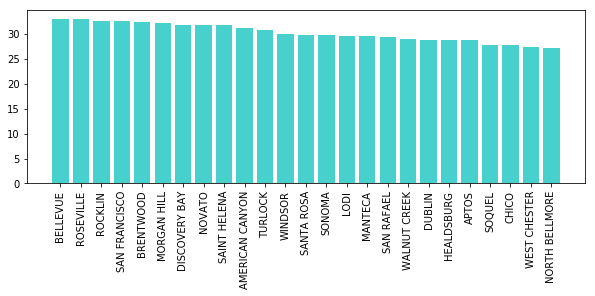

In [45]:
barplot(data_test, 'City', 'Average_Revenue_By_Day')

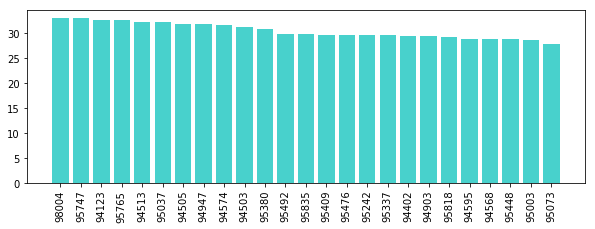

In [46]:
barplot(data_test, 'Zip', 'Average_Revenue_By_Day')

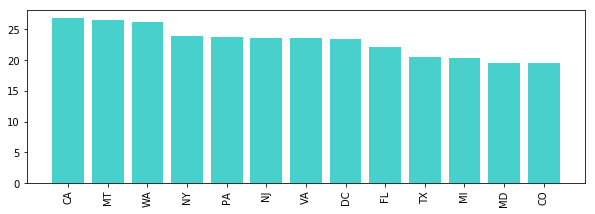

In [47]:
barplot(data_test, 'ST', 'Average_Revenue_By_Day')